In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from collections import OrderedDict
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# Extras needed
import time
import math
from utils import *

In [2]:
# Modify `generate_train_test_split` to return separate data and labels for DataLoader usage
def generate_train_test_split(count: int, dim: int, n: int, device: torch.device, coord_max: float, test_size: float = 0.2, seed: int = 42):
    all_batches = generate_vector_batches(count, dim, n, device, coord_max, seed)
    labels = torch.arange(count)  # Placeholder labels if needed

    train_indices, test_indices = train_test_split(range(count), test_size=test_size, random_state=seed)
    train_batches, test_batches = all_batches[train_indices], all_batches[test_indices]

    return train_batches, test_batches


In [3]:
class Base_Wasser_NN(nn.Module):
    def __init__(self, n: int, d: int):
        super().__init__()
        self.n = n
        self.d = d
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(OrderedDict([
            ('Lin1', nn.Linear(2 * n * d, 4 * n * d)),
            ('relu1', nn.ReLU()),
            ('Lin2', nn.Linear(4 * n * d, n * n + 2 * n))  # n x n matrix and two n-long vectors
        ]))

    def forward(self, batch):
        # Reshape batch to (batch_size, 2 * n * d) for the Linear layer
        batch_size = batch.size(0)
        flattened_batch = batch.view(batch_size, 2 * self.n * self.d)  # (batch_size, 2 * n * d)
        
        # Pass through the sequential layers
        logits = self.linear_relu_stack(flattened_batch)
        return logits
    def predict_interval(self, batch):
        # Unpack batched vectors from the input batch
        vecs1 = batch[:, 0, :, :]  # Shape: (batch_size, n, d)
        vecs2 = batch[:, 1, :, :]  # Shape: (batch_size, n, d)

        # Forward pass to get predictions
        pred = self.forward(batch)  # Now expects batched output of shape (batch_size, n * n + 2 * n)
        batch_size = pred.size(0)
        
        results = []
        for i in range(batch_size):
            # Compute distance matrix for the i-th element in the batch
            distances_mat = torch.cdist(vecs1[i], vecs2[i], p=2)  # Shape: (n, n)
    
            # Separate the i-th prediction output into its components
            single_pred = pred[i]
            out_put_mat = single_pred[:n * n].view(n, n)  # Shape: (n, n)
            f = single_pred[n * n:n * n + n]              # Shape: (n,)
            g = single_pred[n * n + n:]                   # Shape: (n,)
    
            # Compute primal and dual solutions
            sol_prim = primal_sol(out_put_mat=out_put_mat, distances_mat=distances_mat)
            sol_dual = dual_sol(f=f, g=g, distances_mat=distances_mat)
            
            # Append the result (sol_prim, sol_dual) for each batch element
            results.append((sol_prim, sol_dual))
        
        return results  # Returns a list of tuples, each containing (sol_prim, sol_dual) for a batch element


In [4]:
def make_wass_loss(n: int, d: int):
    def wass_loss(batch, pred):
        # Unpack batched vectors from the input batch
        vecs1 = batch[:, 0, :, :]  # Shape: (batch_size, n, d)
        vecs2 = batch[:, 1, :, :]  # Shape: (batch_size, n, d)

        batch_size = pred.size(0)  # Determine batch size from pred

        # Compute distance matrix for each item in the batch
        total_loss = 0
        for i in range(batch_size):
            distances_mat = torch.cdist(vecs1[i], vecs2[i])  # Shape: (n, n)
            
            # Separate the i-th prediction output into its components
            single_pred = pred[i]
            out_put_mat = single_pred[:n * n].view(n, n)  # Shape: (n, n)
            f = single_pred[n * n:n * n + n]              # Shape: (n,)
            g = single_pred[n * n + n:]                   # Shape: (n,)
            
            # Compute primal and dual solutions for each item in the batch
            sol_prim = primal_sol(out_put_mat=out_put_mat, distances_mat=distances_mat)
            sol_dual = dual_sol(f=f, g=g, distances_mat=distances_mat)

            # Check for NaNs in solutions
            if torch.isnan(sol_prim).any():
                print(f"NaN detected in sol_prim {i}")
            if torch.isnan(sol_dual).any():
                print(f"NaN detected in sol_dual {i}")

            # Accumulate loss
            total_loss += torch.abs(sol_prim - sol_dual)

        # Return average loss across the batch
        return total_loss / batch_size if batch_size > 0 else torch.tensor(0.0, device=pred.device)

    return wass_loss


In [5]:
def train_model(model, dataloader, loss_fn, optimizer,max_norm = 2.0):
    model.train()
    for batch in dataloader:
        batch = batch[0].to(device)  # Extract batch tensor from DataLoader tuple
        optimizer.zero_grad()

        # Forward pass
        logits = model(batch)
        
        # Compute loss
        loss = loss_fn(batch, logits)
        
        # Backward pass and optimization step
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_norm)
        optimizer.step()

def test_model(model, dataloader, loss_fn):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch in dataloader:
            batch = batch[0].to(device)
            logits = model(batch)
            loss = loss_fn(batch, logits)
            total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    return avg_loss


## Define Parameters

In [6]:
count = 1000
d = 2
n = 4
seed = 16
device = "cpu"#torch.device("cuda" if torch.cuda.is_available() else "cpu")
coords_max = 10
lr = 1e-2
batch_size = 64  # Define batch size
epochs = 50

## Generating train and test batches

In [7]:
train_batches, test_batches = generate_train_test_split(count=count, dim=d, n=n, device=device, coord_max=coords_max, test_size=0.2, seed=seed)

# Create DataLoaders
train_dataset = TensorDataset(train_batches)
test_dataset = TensorDataset(test_batches)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [8]:
# Model, loss, optimizer
model = Base_Wasser_NN(n=n, d=d).to(device)
loss_fn = make_wass_loss(n=n, d=d)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# Training and testing loop
for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    start_time = time.time()
    # Training
    train_model(model, train_loader, loss_fn, optimizer)
    # Testing
    avg_loss = test_model(model, test_loader, loss_fn)
    print(f"Average Test Loss: {avg_loss:.4f}")
    
    end_time = time.time()
    epoch_duration = end_time - start_time
    print(f"Epoch Run time: {epoch_duration:.2f} seconds.\n")
    print("-------------------------------")

print("Done!")

Epoch 1
-------------------------------
Average Test Loss: 21.1721
Epoch Run time: 1.00 seconds.

-------------------------------
Epoch 2
-------------------------------
Average Test Loss: 20.1345
Epoch Run time: 0.97 seconds.

-------------------------------
Epoch 3
-------------------------------
Average Test Loss: 19.4574
Epoch Run time: 0.96 seconds.

-------------------------------
Epoch 4
-------------------------------
Average Test Loss: 18.9264
Epoch Run time: 0.96 seconds.

-------------------------------
Epoch 5
-------------------------------
Average Test Loss: 18.4705
Epoch Run time: 0.99 seconds.

-------------------------------
Epoch 6
-------------------------------
Average Test Loss: 18.0634
Epoch Run time: 0.96 seconds.

-------------------------------
Epoch 7
-------------------------------
Average Test Loss: 17.7019
Epoch Run time: 1.01 seconds.

-------------------------------
Epoch 8
-------------------------------
Average Test Loss: 17.3688
Epoch Run time: 0.98 se

# Saving and Loading model

In [9]:
model_path = "Trained_models/Basic_net_50_ep_1000_data.pt"

In [10]:
torch.save(model.state_dict(), model_path)

In [11]:
# Loading the model
model = Base_Wasser_NN(n=n, d=d).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()
print("Model loaded successfully.")

Model loaded successfully.


# Bounds Visualization

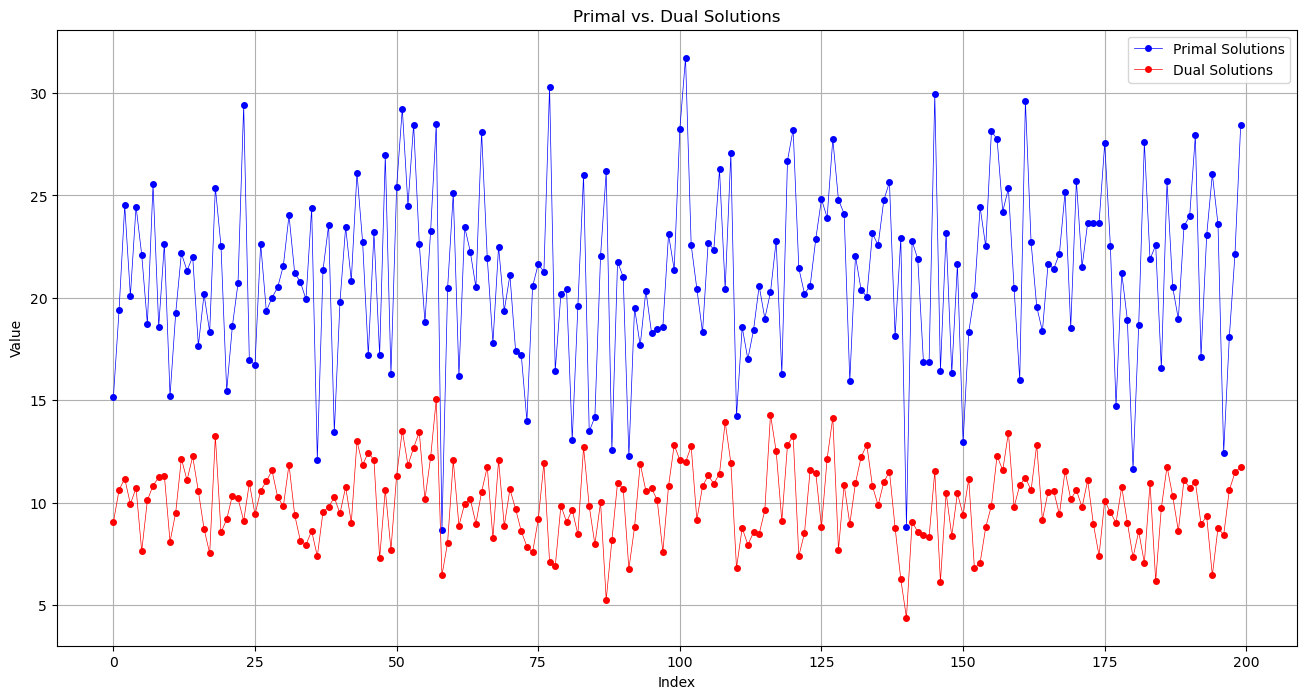

In [12]:
# Set up lists to hold primal and dual solutions
primal_solutions = []
dual_solutions = []
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation for efficiency
    for batch in test_loader:
        sets = batch[0].to(device)

        # Get batched primal and dual solutions
        sets_results = model.predict_interval(sets)
            
        # Separate primal and dual solutions
        for sol_prim, sol_dual in sets_results:
            primal_solutions.append(sol_prim.item())  # Assuming sol_prim is a tensor
            dual_solutions.append(sol_dual.item())    # Assuming sol_dual is a tensor

        # # Since we are breaking after the first batch, we can exit the loop here
        # break  # Remove this line if you want to process more batches

# Convert to numpy arrays for easier plotting
primal_solutions = np.array(primal_solutions)
dual_solutions = np.array(dual_solutions)

# Plotting the results
plt.figure(figsize=(16, 8))

# Plot primal solutions in blue
plt.plot(primal_solutions, label='Primal Solutions', color='blue', marker='o', linestyle='-',linewidth = 0.5,markersize = 4)

# Plot dual solutions in red
plt.plot(dual_solutions, label='Dual Solutions', color='red', marker='o', linestyle='-',linewidth = 0.5,markersize = 4)

plt.title('Primal vs. Dual Solutions')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

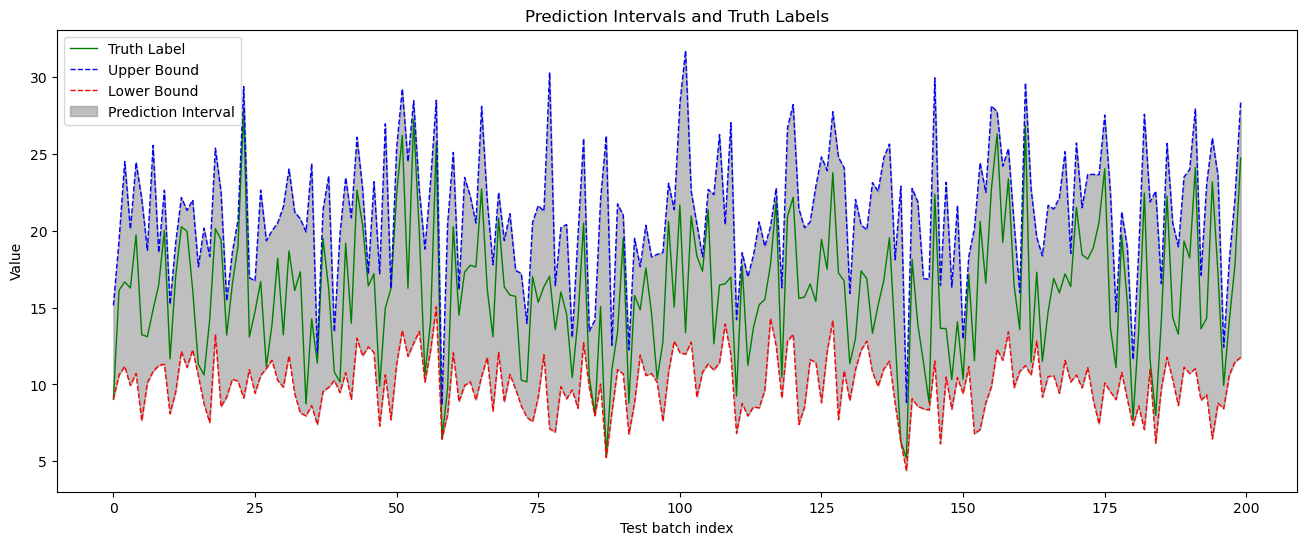

In [13]:
preds = [(dual,primal) for dual,primal in zip(dual_solutions,primal_solutions)]
x = range(len(test_batches))  # x-axis values (can be indices or actual values)
primal_bounds = [pred[1] for pred in preds]
dual_bounds = [pred[0] for pred in preds]
true_label = [wass_hungarian(input).cpu() for input in test_batches]         # True label (ground truth)

# Plotting
plt.figure(figsize=(16, 6))
plt.plot(x, true_label, label='Truth Label', color='green', linewidth=1)
plt.plot(x, primal_bounds, label='Upper Bound', color='blue', linestyle='--', linewidth=1)
plt.plot(x, dual_bounds, label='Lower Bound', color='red', linestyle='--', linewidth=1)

# Shading the area between the lower and upper bounds
plt.fill_between(x, dual_bounds, primal_bounds, color='gray', alpha=0.5, label='Prediction Interval')

# Labels and legend
plt.xlabel('Test batch index')
plt.ylabel('Value')
plt.title('Prediction Intervals and Truth Labels')
plt.legend()

# Show the plot
plt.show()


In [14]:
validity_array = np.array(primal_solutions) > np.array(dual_solutions)
if(False in validity_array):
    print("There is a problem")
else:
    print("Seems to work")

Seems to work


## Trying optimized predict_interval

In [15]:
def predict_interval_opt(batch,model,n=4,d=2):
    # Unpack batched vectors from the input batch
    vecs1 = batch[:, 0, :, :]  # Shape: (batch_size, n, d)
    vecs2 = batch[:, 1, :, :]  # Shape: (batch_size, n, d)

    # Forward pass to get predictions for all elements at once
    pred = model.forward(batch)  # Expected shape: (batch_size, n * n + 2 * n)
    batch_size, n, _ = vecs1.shape
    
    # Compute the distance matrices for the whole batch at once
    distances_mat_batch = torch.cdist(vecs1, vecs2, p=2)  # Shape: (batch_size, n, n)

    # Separate out `out_put_mat`, `f`, and `g` from `pred` for the whole batch at once
    out_put_mat_batch = pred[:, :n * n].view(batch_size, n, n)   # Shape: (batch_size, n, n)
    f_batch = pred[:, n * n:n * n + n]                           # Shape: (batch_size, n)
    g_batch = pred[:, n * n + n:]                                # Shape: (batch_size, n)

    # Compute solutions for all elements in parallel or vectorized form if possible
    results = []
    for i in range(batch_size):
        sol_prim = primal_sol(out_put_mat=out_put_mat_batch[i], distances_mat=distances_mat_batch[i])
        sol_dual = dual_sol(f=f_batch[i], g=g_batch[i], distances_mat=distances_mat_batch[i])
        results.append((sol_prim, sol_dual))

    return results

In [16]:
i=0
start_time = time.time()
for batch in test_loader:
    # Get batched primal and dual solutions
    i+=1
    # print(len(batch[0])) == 64
    predict_interval_opt(batch[0],model)
end_time = time.time()
print(f"Time taken:(Optimized predict_interval) {end_time - start_time}")
print(i)

Time taken:(Optimized predict_interval) 0.11607742309570312
4


# Stress training a model

In [17]:
count = 2000
d = 2
n = 4
seed = 16
device = "cpu"#torch.device("cuda" if torch.cuda.is_available() else "cpu")
coords_max = 10
lr = 1e-2
batch_size = 64  # Define batch size
epochs = 150

In [18]:
train_batches, test_batches = generate_train_test_split(count=count, dim=d, n=n, device=device, coord_max=coords_max, test_size=0.2, seed=seed)

# Create DataLoaders
train_dataset = TensorDataset(train_batches)
test_dataset = TensorDataset(test_batches)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [19]:
# Model, loss, optimizer
model = Base_Wasser_NN(n=n, d=d).to(device)
loss_fn = make_wass_loss(n=n, d=d)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# Training and testing loop
for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    start_time = time.time()
    # Training
    train_model(model, train_loader, loss_fn, optimizer)
    # Testing
    avg_loss = test_model(model, test_loader, loss_fn)
    print(f"Average Test Loss: {avg_loss:.4f}")
    
    end_time = time.time()
    epoch_duration = end_time - start_time
    print(f"Epoch Run time: {epoch_duration:.2f} seconds.\n")
    print("-------------------------------")

print("Done!")

Epoch 1
-------------------------------
Average Test Loss: 20.5962
Epoch Run time: 2.04 seconds.

-------------------------------
Epoch 2
-------------------------------
Average Test Loss: 19.0871
Epoch Run time: 2.19 seconds.

-------------------------------
Epoch 3
-------------------------------
Average Test Loss: 18.1887
Epoch Run time: 2.03 seconds.

-------------------------------
Epoch 4
-------------------------------
Average Test Loss: 17.4992
Epoch Run time: 2.10 seconds.

-------------------------------
Epoch 5
-------------------------------
Average Test Loss: 16.9216
Epoch Run time: 2.11 seconds.

-------------------------------
Epoch 6
-------------------------------
Average Test Loss: 16.4091
Epoch Run time: 2.09 seconds.

-------------------------------
Epoch 7
-------------------------------
Average Test Loss: 15.9552
Epoch Run time: 2.01 seconds.

-------------------------------
Epoch 8
-------------------------------
Average Test Loss: 15.5254
Epoch Run time: 2.07 se

# Saving and loading model 

In [20]:
model_path = "Trained_models/Basic_net_150_ep_2000_data.pt"

In [21]:
torch.save(model.state_dict(), model_path)

In [22]:
# Loading the model
model = Base_Wasser_NN(n=n, d=d).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()
print("Model loaded successfully.")

Model loaded successfully.


# Visualization of stress trained model

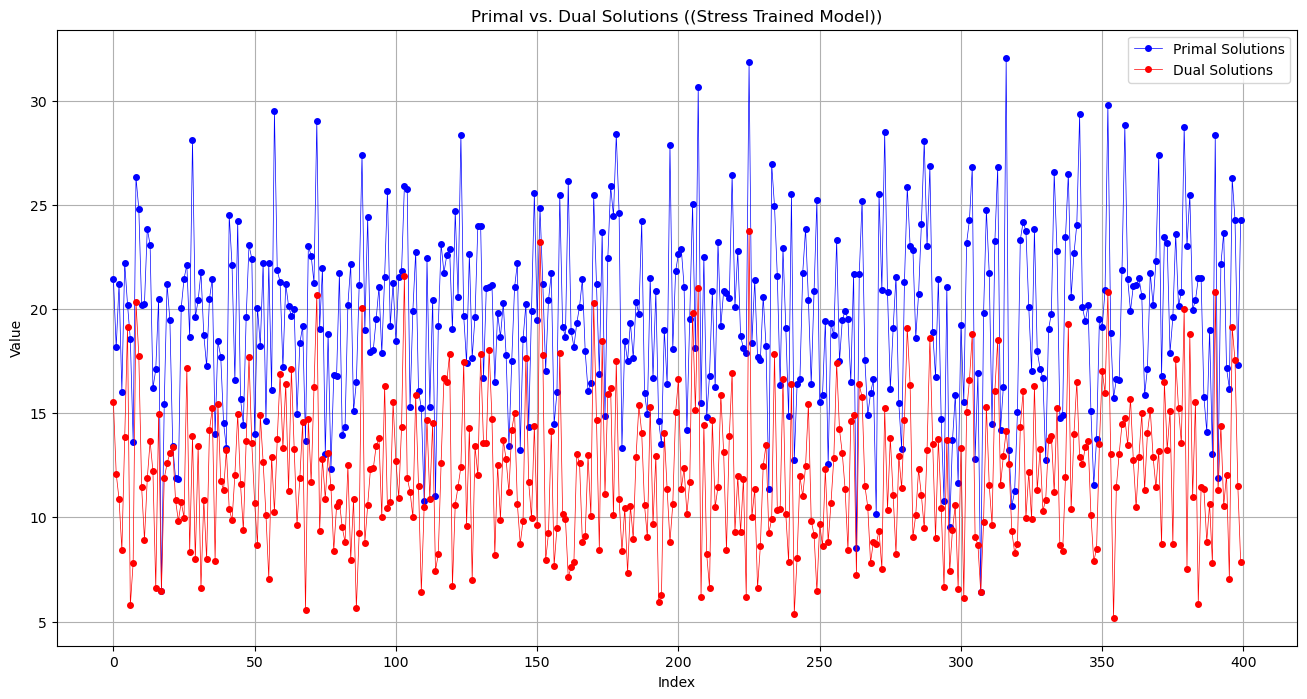

In [23]:
# Set up lists to hold primal and dual solutions
primal_solutions = []
dual_solutions = []
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation for efficiency
    for batch in test_loader:
        sets = batch[0].to(device)

        # Get batched primal and dual solutions
        sets_results = model.predict_interval(sets)
            
        # Separate primal and dual solutions
        for sol_prim, sol_dual in sets_results:
            primal_solutions.append(sol_prim.item())  # Assuming sol_prim is a tensor
            dual_solutions.append(sol_dual.item())    # Assuming sol_dual is a tensor

        # # Since we are breaking after the first batch, we can exit the loop here
        # break  # Remove this line if you want to process more batches

# Convert to numpy arrays for easier plotting
primal_solutions = np.array(primal_solutions)
dual_solutions = np.array(dual_solutions)

# Plotting the results
plt.figure(figsize=(16, 8))

# Plot primal solutions in blue
plt.plot(primal_solutions, label='Primal Solutions', color='blue', marker='o', linestyle='-',linewidth = 0.5,markersize = 4)

# Plot dual solutions in red
plt.plot(dual_solutions, label='Dual Solutions', color='red', marker='o', linestyle='-',linewidth = 0.5,markersize = 4)

plt.title('Primal vs. Dual Solutions ((Stress Trained Model))')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

In [24]:
validity_array = np.array(primal_solutions) > np.array(dual_solutions)
if(False in validity_array):
    print("There is a problem")
else:
    print("Seems to work")

Seems to work


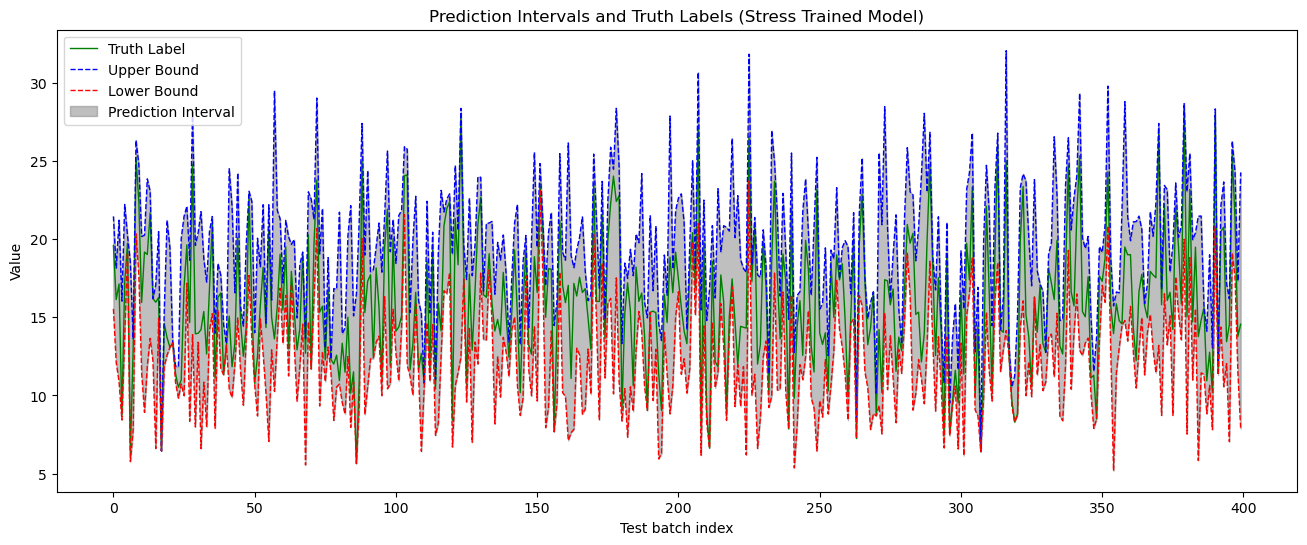

In [25]:
preds = [(dual,primal) for dual,primal in zip(dual_solutions,primal_solutions)]
x = range(len(test_batches))  # x-axis values (can be indices or actual values)
primal_bounds = [pred[1] for pred in preds]
dual_bounds = [pred[0] for pred in preds]
true_label = [wass_hungarian(input).cpu() for input in test_batches]         # True label (ground truth)

# Plotting
plt.figure(figsize=(16, 6))
plt.plot(x, true_label, label='Truth Label', color='green', linewidth=1)
plt.plot(x, primal_bounds, label='Upper Bound', color='blue', linestyle='--', linewidth=1)
plt.plot(x, dual_bounds, label='Lower Bound', color='red', linestyle='--', linewidth=1)

# Shading the area between the lower and upper bounds
plt.fill_between(x, dual_bounds, primal_bounds, color='gray', alpha=0.5, label='Prediction Interval')

# Labels and legend
plt.xlabel('Test batch index')
plt.ylabel('Value')
plt.title('Prediction Intervals and Truth Labels (Stress Trained Model)')
plt.legend()

# Show the plot
plt.show()



# Trying a Different Architecture, O(n²log(n)d) time
* Same parameters first, then larger n

In [36]:
class Logarithmic_Wasser_NN(nn.Module):
    def __init__(self, n: int, d: int):
        super().__init__()
        self.n = n
        self.d = d
        self.flatten = nn.Flatten()
        hidden_size = math.ceil(math.log2(n)) * d *2
        self.linear_relu_stack = nn.Sequential(OrderedDict([
            ('Lin1', nn.Linear(2 * n * d, hidden_size)),
            ('relu1', nn.ReLU()),
            ('Lin2', nn.Linear(hidden_size, n * n + 2 * n))  # n x n matrix and two n-long vectors
        ]))

    def forward(self, batch):
        # Reshape batch to (batch_size, 2 * n * d) for the Linear layer
        batch_size = batch.size(0)
        flattened_batch = batch.view(batch_size, 2 * self.n * self.d)  # (batch_size, 2 * n * d)
        
        # Pass through the sequential layers
        logits = self.linear_relu_stack(flattened_batch)
        return logits
    def predict_interval(self, batch):
        # Unpack batched vectors from the input batch
        vecs1 = batch[:, 0, :, :]  # Shape: (batch_size, n, d)
        vecs2 = batch[:, 1, :, :]  # Shape: (batch_size, n, d)

        # Forward pass to get predictions
        pred = self.forward(batch)  # Now expects batched output of shape (batch_size, n * n + 2 * n)
        batch_size = pred.size(0)
        
        results = []
        for i in range(batch_size):
            # Compute distance matrix for the i-th element in the batch
            distances_mat = torch.cdist(vecs1[i], vecs2[i], p=2)  # Shape: (n, n)
    
            # Separate the i-th prediction output into its components
            single_pred = pred[i]
            out_put_mat = single_pred[:n * n].view(n, n)  # Shape: (n, n)
            f = single_pred[n * n:n * n + n]              # Shape: (n,)
            g = single_pred[n * n + n:]                   # Shape: (n,)
    
            # Compute primal and dual solutions
            sol_prim = primal_sol(out_put_mat=out_put_mat, distances_mat=distances_mat)
            sol_dual = dual_sol(f=f, g=g, distances_mat=distances_mat)
            
            # Append the result (sol_prim, sol_dual) for each batch element
            results.append((sol_prim, sol_dual))
        
        return results  # Returns a list of tuples, each containing (sol_prim, sol_dual) for a batch element


# Defining Training And Evaluation Process frunction

In [37]:
def train_and_evaluate(model_class,train_loader,test_loader, count, d, n, device, coords_max, batch_size, lr, epochs, seed):
    """
    Train and evaluate a model.

    Parameters:
    - model_class: The model class to be instantiated.
    - count: The number of samples.
    - d: Dimensionality of the data.
    - n: Number of data points.
    - device: The device to run the model on (e.g., 'cuda' or 'cpu').
    - coords_max: Maximum coordinate value for the data generation.
    - batch_size: Batch size for training and testing.
    - lr: Learning rate for the optimizer.
    - epochs: Number of training epochs.
    - seed: Random seed for reproducibility.

    Returns:
    - A list of average test losses per epoch.
    """

    # Initialize model, loss, and optimizer
    model = model_class(n=n, d=d).to(device)
    loss_fn = make_wass_loss(n=n, d=d)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    # Initialize list to store average test loss per epoch
    test_losses = []

    # Training and testing loop
    for t in range(epochs):
        print(f"Epoch {t + 1}\n-------------------------------")
        start_time = time.time()

        # Training
        train_model(model, train_loader, loss_fn, optimizer)

        # Testing
        avg_loss = test_model(model, test_loader, loss_fn)
        test_losses.append(avg_loss)
        print(f"Average Test Loss: {avg_loss:.4f}")

        end_time = time.time()
        epoch_duration = end_time - start_time
        print(f"Epoch Run time: {epoch_duration:.2f} seconds.\n")
        print("-------------------------------")

    print("Done!")
    
    # Return the list of average test losses
    return model,test_losses


In [38]:
# Define parameters
count = 2000
d = 2
n = 4
seed = 16
device = "cpu"#torch.device("cuda" if torch.cuda.is_available() else "cpu")
coords_max = 10
lr = 1e-2
batch_size = 64
epochs = 150
# Generate train/test split
train_batches, test_batches = generate_train_test_split(
    count=count, dim=d, n=n, device=device, coord_max=coords_max, test_size=0.2, seed=seed
)

# Create DataLoaders
train_dataset = TensorDataset(train_batches)
test_dataset = TensorDataset(test_batches)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
# Call the function

In [39]:
model,test_losses = train_and_evaluate(
    model_class=Logarithmic_Wasser_NN,
    train_loader = train_loader,
    test_loader=test_loader,
    count=count,
    d=d,
    n=n,
    device=device,
    coords_max=coords_max,
    batch_size=batch_size,
    lr=lr,
    epochs=epochs,
    seed=seed
)

Epoch 1
-------------------------------
Average Test Loss: 21.0903
Epoch Run time: 2.59 seconds.

-------------------------------
Epoch 2
-------------------------------
Average Test Loss: 20.0773
Epoch Run time: 2.62 seconds.

-------------------------------
Epoch 3
-------------------------------
Average Test Loss: 19.3669
Epoch Run time: 2.63 seconds.

-------------------------------
Epoch 4
-------------------------------
Average Test Loss: 18.7526
Epoch Run time: 2.63 seconds.

-------------------------------
Epoch 5
-------------------------------
Average Test Loss: 18.2073
Epoch Run time: 2.63 seconds.

-------------------------------
Epoch 6
-------------------------------
Average Test Loss: 17.6866
Epoch Run time: 2.63 seconds.

-------------------------------
Epoch 7
-------------------------------
Average Test Loss: 17.2115
Epoch Run time: 2.68 seconds.

-------------------------------
Epoch 8
-------------------------------
Average Test Loss: 16.7410
Epoch Run time: 2.74 se

# Saving and loading model

In [40]:
model_path = "Trained_models/Logarithmic_net_150_ep_2000_data.pt"

In [41]:
torch.save(model.state_dict(), model_path)

In [42]:
# Loading the model
model = Logarithmic_Wasser_NN(n=n, d=d).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()
print("Model loaded successfully.")

Model loaded successfully.


# A couple more epochs

In [43]:
# loss_fn = make_wass_loss(n=n, d=d)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# epochs = 20
#     # Training and testing loop
# for t in range(epochs):
#     print(f"Epoch {t + 1}\n-------------------------------")
#     start_time = time.time()
#     # Training
#     train_model(model, train_loader, loss_fn, optimizer)
#     # Testing
#     avg_loss = test_model(model, test_loader, loss_fn)
#     print(f"Average Test Loss: {avg_loss:.4f}")

#     end_time = time.time()
#     epoch_duration = end_time - start_time
#     print(f"Epoch Run time: {epoch_duration:.2f} seconds.\n")
#     print("-------------------------------")

# print("Done!")

# Visualization function

In [71]:
def plot_combined_prediction_intervals(model, test_loader, test_batches, device, plot_title):
    """
    Plots the prediction intervals (primal and dual solutions) alongside the ground truth for a given model.
    Displays three subplots:
    - Unsorted data
    - Data sorted by primal-dual difference
    - Data sorted by dual solutions
    
    Parameters:
    - model: Trained model used for predictions.
    - test_loader: DataLoader containing the test data.
    - test_batches: Original test data (list or tensor), used for the ground truth comparison.
    - wass_hungarian: Function to compute the ground truth label.
    - device: Device to perform computations on (e.g., 'cuda' or 'cpu').
    - plot_title: Title for the entire plot.
    """
    
    # Lists to hold primal and dual solutions
    primal_solutions = []
    dual_solutions = []
    
    # Set model to evaluation mode and disable gradients
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            sets = batch[0].to(device)

            # Get batched primal and dual solutions from model predictions
            sets_results = model.predict_interval(sets)
            
            # Separate primal and dual solutions
            for sol_prim, sol_dual in sets_results:
                primal_solutions.append(sol_prim.item())
                dual_solutions.append(sol_dual.item())

    # Convert solutions to numpy arrays for plotting
    primal_solutions = np.array(primal_solutions)
    dual_solutions = np.array(dual_solutions)

    # Validity check
    if not all(primal_solutions > dual_solutions):
        print("There is a problem: some primal solutions are not greater than dual solutions.")
    else:
        print("Solutions seem valid.")

    # Calculate primal-dual differences
    primal_dual_diff = primal_solutions - dual_solutions
    
    # Sort indices for each of the three plots
    unsorted_indices = np.arange(len(test_batches))
    sorted_by_difference_indices = np.argsort(primal_dual_diff)
    sorted_by_dual_indices = np.argsort(dual_solutions)
    
    # Prepare sorted and unsorted data for plotting
    primal_unsorted = primal_solutions[unsorted_indices]
    dual_unsorted = dual_solutions[unsorted_indices]
    true_label_unsorted = [wass_hungarian(test_batches[i]).cpu().item() for i in unsorted_indices]

    primal_sorted_diff = primal_solutions[sorted_by_difference_indices]
    dual_sorted_diff = dual_solutions[sorted_by_difference_indices]
    true_label_sorted_diff = [wass_hungarian(test_batches[i]).cpu().item() for i in sorted_by_difference_indices]

    primal_sorted_dual = primal_solutions[sorted_by_dual_indices]
    dual_sorted_dual = dual_solutions[sorted_by_dual_indices]
    true_label_sorted_dual = [wass_hungarian(test_batches[i]).cpu().item() for i in sorted_by_dual_indices]
    
    # Set up the figure with vertical subplots
    fig, axs = plt.subplots(3, 1, figsize=(16, 16))
    x = range(len(test_batches))


    # Visual Parameters:
    TITLE_FONT_SIZE = 20
    # Plot 1: Unsorted
    axs[0].plot(x, true_label_unsorted, label='Truth Label', color='green', linewidth=1)
    axs[0].plot(x, primal_unsorted, label='Upper Bound', color='blue', linestyle='--', linewidth=1)
    axs[0].plot(x, dual_unsorted, label='Lower Bound', color='red', linestyle='--', linewidth=1)
    axs[0].fill_between(x, dual_unsorted, primal_unsorted, color='gray', alpha=0.5, label='Prediction Interval')
    axs[0].set_title('Unsorted',fontsize=TITLE_FONT_SIZE)
    axs[0].set_xlabel('Test batch index')
    axs[0].set_ylabel('Value')

    # Plot 2: Sorted by Primal-Dual Difference
    axs[1].plot(x, true_label_sorted_diff, label='Truth Label', color='green', linewidth=1)
    axs[1].plot(x, primal_sorted_diff, label='Upper Bound', color='blue', linestyle='--', linewidth=1)
    axs[1].plot(x, dual_sorted_diff, label='Lower Bound', color='red', linestyle='--', linewidth=1)
    axs[1].fill_between(x, dual_sorted_diff, primal_sorted_diff, color='gray', alpha=0.5, label='Prediction Interval')
    axs[1].set_title('Sorted by Primal-Dual Difference',fontsize=TITLE_FONT_SIZE)
    axs[1].set_xlabel('Sorted Test batch index')

    # Plot 3: Sorted by Dual Solution
    axs[2].plot(x, true_label_sorted_dual, label='Truth Label', color='green', linewidth=1)
    axs[2].plot(x, primal_sorted_dual, label='Upper Bound', color='blue', linestyle='--', linewidth=1)
    axs[2].plot(x, dual_sorted_dual, label='Lower Bound', color='red', linestyle='--', linewidth=1)
    axs[2].fill_between(x, dual_sorted_dual, primal_sorted_dual, color='gray', alpha=0.5, label='Prediction Interval')
    axs[2].set_title('Sorted by Dual Solution',fontsize=TITLE_FONT_SIZE)
    axs[2].set_xlabel('Sorted Test batch index')
    
    # Overall legend and title
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=4)
    fig.suptitle(plot_title,fontsize=TITLE_FONT_SIZE)
    
    # Show the plot
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


Solutions seem valid.


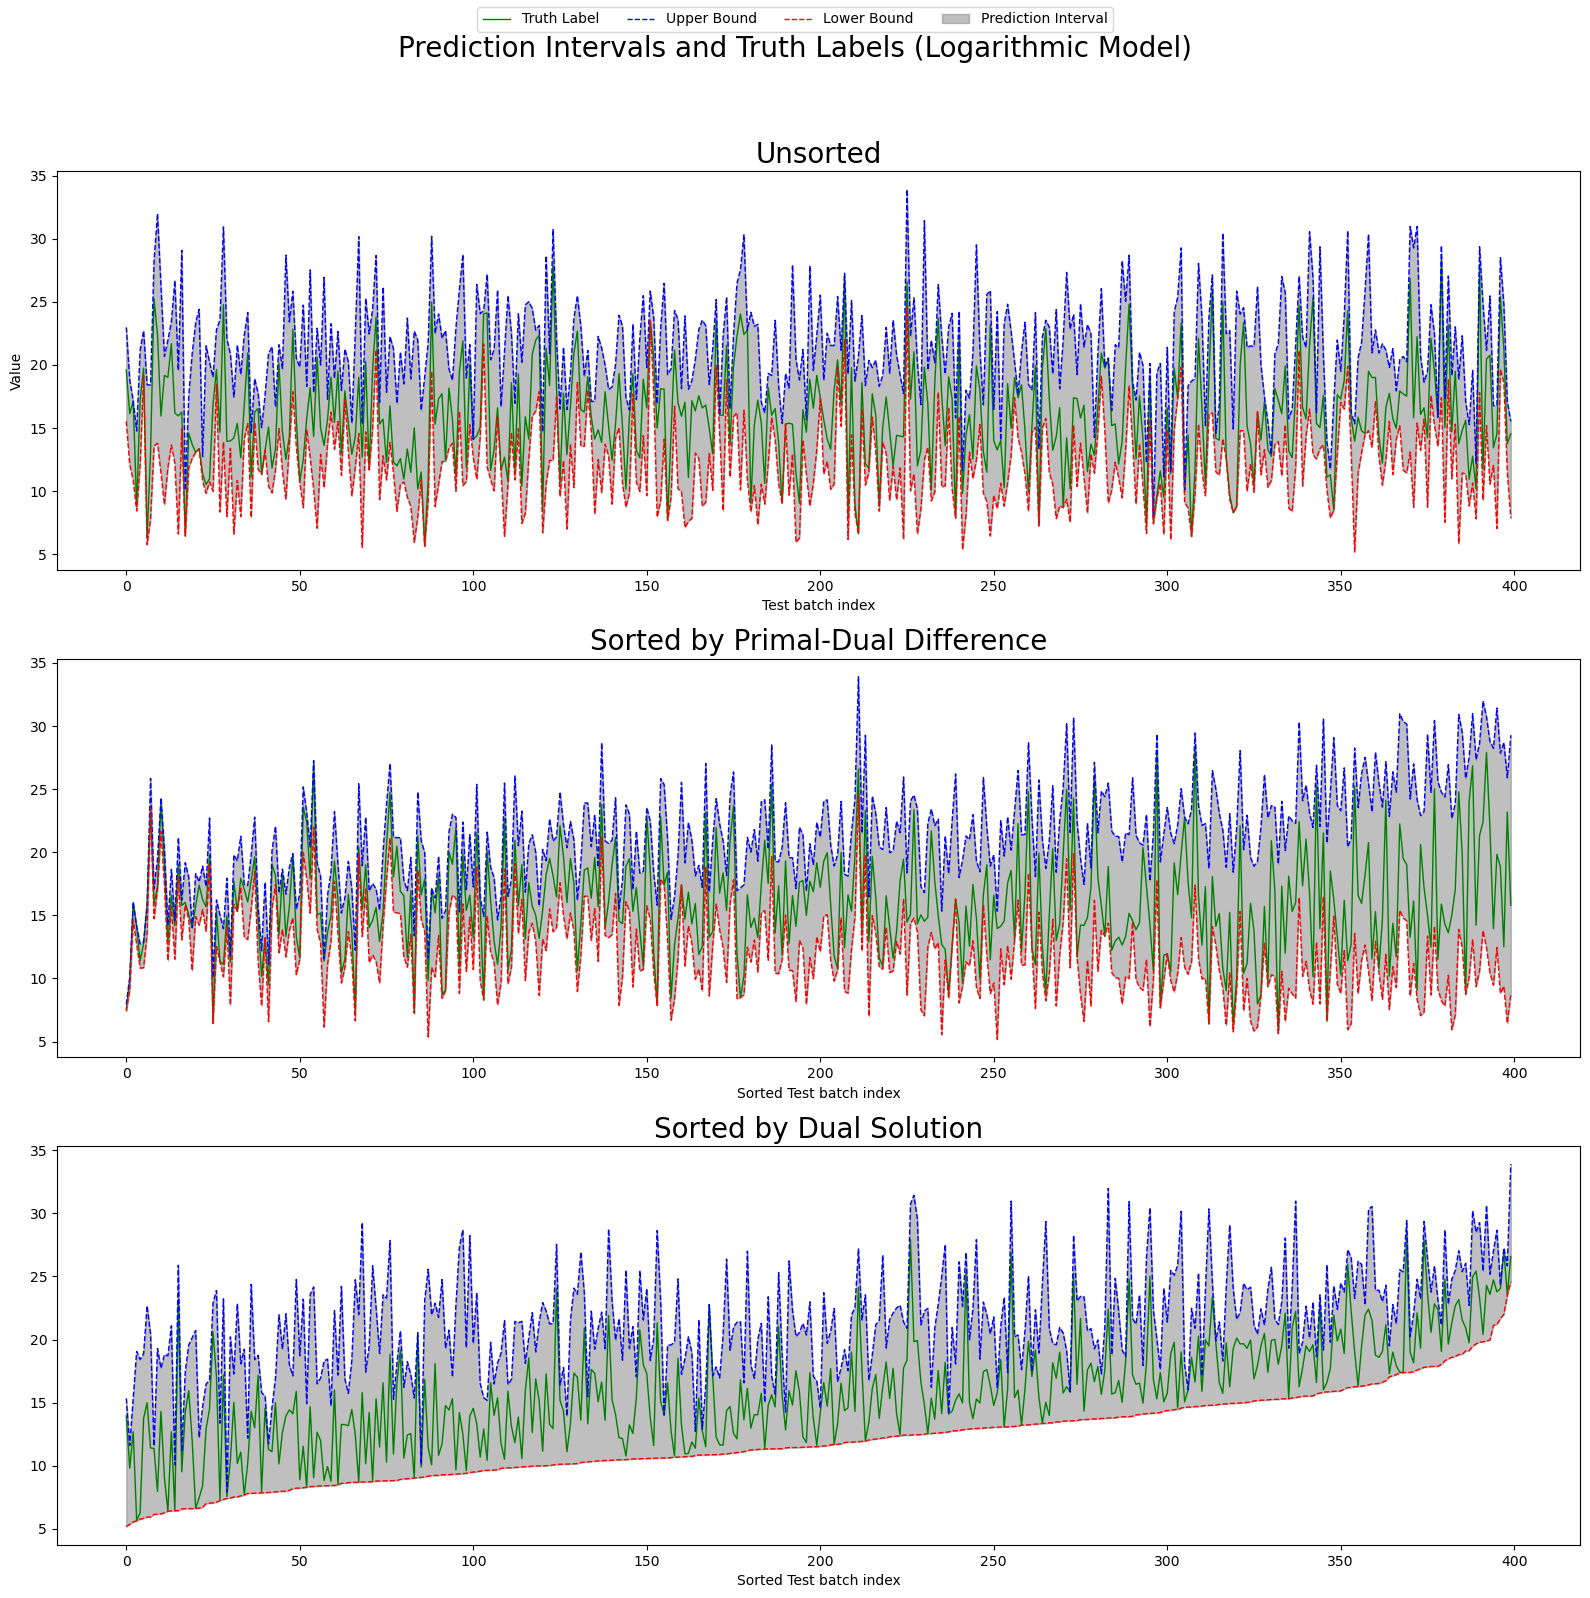

In [72]:
plot_combined_prediction_intervals(
    model=model,
    test_loader=test_loader,
    test_batches=test_batches,
    device=device,
    plot_title="Prediction Intervals and Truth Labels (Logarithmic Model)"
)